In [1]:
import math

import torch
from contextual_gaussian import (ContextualGaussianDataset,
                                 contextual_gaussian,
                                 contextual_gaussian_tuple)
from dvi_process import DIS, zTuple
from matplotlib import pyplot as plt
from score_function import ScoreFunction
from torch.distributions import Normal
from torch.utils.data import DataLoader
from train import train

In [2]:
import torch_directml

device = torch_directml.device()

In [3]:
dataset = ContextualGaussianDataset(size=1000)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

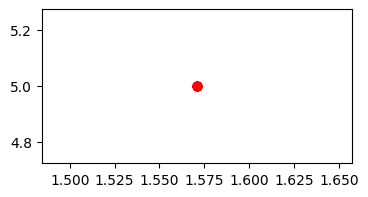

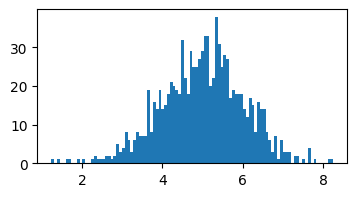

In [6]:
batch = next(iter(dataloader))

contextual_gaussians = [contextual_gaussian(x, 1) for x in batch]
samples = contextual_gaussians[0].sample((1000,))

plt.figure(figsize=(4, 2))
plt.scatter(batch, [g.mean for g in contextual_gaussians], color="red")
plt.show()

plt.figure(figsize=(4, 2))
plt.hist(samples, bins=100)
plt.show()

In [5]:
c_dim = 1
z_dim = 1
h_dim = 32
num_layers = 3
non_linearity = "ReLU"
num_steps = 16
learning_rate = 1e-4

In [6]:
score_function = ScoreFunction(c_dim=c_dim, h_dim=h_dim, z_dim=z_dim, num_layers=num_layers, non_linearity=non_linearity, num_steps=num_steps)
dis = DIS(z_dim=z_dim, num_steps=num_steps, score_function=score_function).to(device)

optimizer = torch.optim.Adam(dis.parameters(), lr=learning_rate)

In [7]:
import wandb

wandb_logging = True
if wandb_logging:
    wandb.init(project="dvi")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: max-burzer (max-burzer-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


In [15]:
losses = train(dis, device, dataloader, optimizer, 40, wandb_logging=wandb_logging)

100%|██████████| 32/32 [00:12<00:00,  2.62it/s, epoch=39, loss=12]  


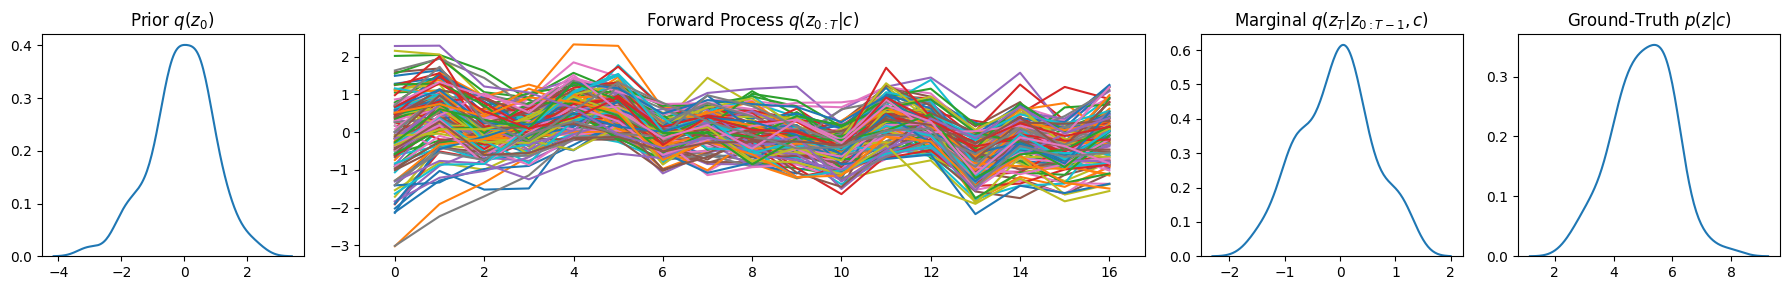

In [20]:
import seaborn as sns

num_samples = 128

context = torch.ones((z_dim), device=device) * math.pi/2

z_0_mu = torch.zeros((num_samples, z_dim), device=device)
z_0_sigma = torch.ones((num_samples, z_dim), device=device)
z_0 = torch.normal(z_0_mu, z_0_sigma).to(device)
z_0_tuple = zTuple(z_0, z_0_mu, z_0_sigma)

dis.eval()
with torch.no_grad():
    z_tuples = dis.forward_process(z_0_tuple, context.unsqueeze(0).repeat(num_samples, 1), None)

z_0_samples = z_tuples[0].z.squeeze(1).tolist()
z_T_samples = z_tuples[-1].z.squeeze(1).tolist()

z_trajectories = [[z_tuple.z[i].cpu().numpy() for z_tuple in z_tuples] for i in range(num_samples)]

z_ground_truth_tuple = contextual_gaussian_tuple(context.cpu())
z_ground_truth_samples = Normal(z_ground_truth_tuple.z_mu, z_ground_truth_tuple.z_sigma).sample((num_samples,)).squeeze(1).tolist()

fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 3, 1, 1]})

sns.kdeplot(z_0_samples, ax=ax[0])
ax[0].set_title("Prior $q(z_0)$")
ax[0].set_ylabel(None)

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("Forward Process $q(z_{0:T}|c)$")

sns.kdeplot(z_T_samples, ax=ax[2])
ax[2].set_title("Marginal $q(z_T|z_{0:T-1},c)$")
ax[2].set_ylabel(None)

sns.kdeplot(z_ground_truth_samples, ax=ax[3])
ax[3].set_title("Ground-Truth $p(z|c)$")
ax[3].set_ylabel(None)

plt.tight_layout()
plt.show()